# 定义无标签数据集类

In [5]:
import numpy as np 
import os 
from torch.utils.data import Dataset, DataLoader

class UnlabeledMelFrequencyDataset(Dataset):
    def __init__(self, data_dir, max_seq_length=300):
        self.data = []
        self.max_seq_length = max_seq_length
        data_files = sorted(os.listdir(data_dir))  # 对文件列表进行排序
        for file in data_files:
            file_path = os.path.join(data_dir, file)
            self.data.append(file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data[idx]
        # 加载无标签梅尔频率数据
        mel_data = np.load(file_path)  # 假设是.npy格式的文件
        # 对数据进行填充或截断
        if mel_data.shape[0] < self.max_seq_length:
            # 填充到最大长度
            pad_length = self.max_seq_length - mel_data.shape[0]
            mel_data = np.pad(mel_data, ((0, pad_length), (0, 0)), mode='constant', constant_values=0)
        elif mel_data.shape[0] > self.max_seq_length:
            # 截断到最大长度
            mel_data = mel_data[:self.max_seq_length, :]
        # 将梅尔频率特征转换为PyTorch张量并返回
        return torch.tensor(mel_data)

# 载入预测数据集

In [2]:
# 创建无标签数据集对象
unlabeled_dataset = UnlabeledMelFrequencyDataset(data_dir='data/test_data', max_seq_length=30)
# 创建数据加载器
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=False)

# 确认按文件顺序排列
# 打印出前 10 个文件路径
for i in range(20):
    print(unlabeled_dataset.data[i])

data/test_data/test_0001.npy
data/test_data/test_0002.npy
data/test_data/test_0003.npy
data/test_data/test_0004.npy
data/test_data/test_0005.npy
data/test_data/test_0006.npy
data/test_data/test_0007.npy
data/test_data/test_0008.npy
data/test_data/test_0009.npy
data/test_data/test_0010.npy
data/test_data/test_0011.npy
data/test_data/test_0012.npy
data/test_data/test_0013.npy
data/test_data/test_0014.npy
data/test_data/test_0015.npy
data/test_data/test_0016.npy
data/test_data/test_0017.npy
data/test_data/test_0018.npy
data/test_data/test_0019.npy
data/test_data/test_0020.npy


# 完成预测任务

In [6]:
import torch
import models.network as models
from torch.utils.data import Dataset, DataLoader

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义模型结构
model = models.MelCNN(unlabeled_dataset[0].shape,2).to(device)
# 加载已保存的模型参数
model.load_state_dict(torch.load('saved_models/model_cnn_v2.pth'))
# 将模型设置为评估模式
model.eval()

# 使用模型进行预测
predictions = []
for inputs in unlabeled_loader:
    inputs = inputs.to(device)  # 将输入数据移动到设备上
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)  # 获取预测结果
    predictions.extend(predicted.tolist())


In [8]:
# 检查预测结果
import pandas as pd
import os
# 提取文件名
file_names = [os.path.basename(file) for file in unlabeled_dataset.data]
# 创建包含预测结果的DataFrame
data = {'file': file_names, 'label': predictions}
df = pd.DataFrame(data)
print(df)
# 检查标签总数
print(predictions.count(0),predictions.count(1))
# 将DataFrame写入Excel文件
df.to_csv('test.csv', index=False)

                              file  label
0     data/test_data/test_0001.npy      0
1     data/test_data/test_0002.npy      0
2     data/test_data/test_0003.npy      0
3     data/test_data/test_0004.npy      0
4     data/test_data/test_0005.npy      1
...                            ...    ...
1995  data/test_data/test_1996.npy      0
1996  data/test_data/test_1997.npy      1
1997  data/test_data/test_1998.npy      0
1998  data/test_data/test_1999.npy      1
1999  data/test_data/test_2000.npy      0

[2000 rows x 2 columns]
1171 829


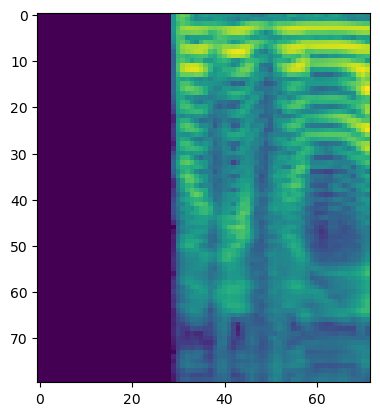

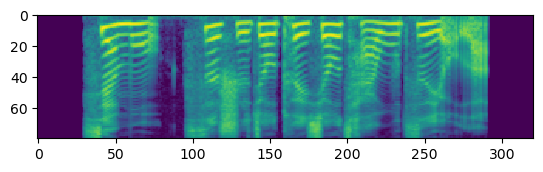

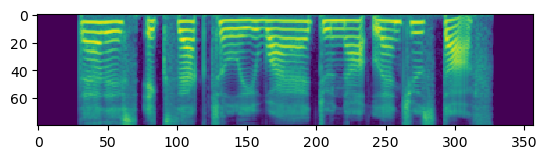

In [5]:
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt

def plotmel(filepath):
    # 从文件中加载梅尔频谱
    mel_spec = np.load(filepath)
    plt.imshow(mel_spec.T, cmap='viridis', interpolation='nearest')
    plt.show()


plotmel("data/test_data/test_1997.npy")
plotmel("data/train_data/language_0/F001_010.npy")
plotmel("data/train_data/language_1/F001_007.npy")